# 드라이브 연동

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Feb 13 05:27:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
%cd /content/gdrive/My\ Drive/tobigs/snorrr

/content/gdrive/My Drive/tobigs/snorrr


In [ ]:
#zip file을 내 드라이브에 다운받아야함
# !mkdir ./beep_data
# !unzip XY_train.zip -d ./beep_data
# !unzip XY_test.zip -d ./beep_data

# Data Check

In [ ]:
n_freq = 128  # 스펙트로그램 높이

# Data Loader
- with Keras

In [ ]:
%cd /content/gdrive/My\ Drive/tobigs/snorrr

/content/gdrive/My Drive/tobigs/snorrr


In [ ]:
import os 
import pandas as pd
import numpy as np
from keras.utils import Sequence 

Using TensorFlow backend.


In [ ]:
data_dir = os.path.join('.','beep_data', 'XY_train')
x_s = []
y_s = []
for file in os.listdir(data_dir):
    if file.startswith('x_'):
        x_s.append(os.path.join(data_dir,file))
    elif file.startswith('y_'):
        y_s.append(os.path.join(data_dir,file))
    x_s = sorted(x_s)
    y_s = sorted(y_s)
df = pd.DataFrame({'x':x_s, 'y':y_s})
df.head()

,x,y
0,./beep_data/XY_train/x_0.npy,./beep_data/XY_train/y_0.npy
1,./beep_data/XY_train/x_1.npy,./beep_data/XY_train/y_1.npy
2,./beep_data/XY_train/x_10.npy,./beep_data/XY_train/y_10.npy
3,./beep_data/XY_train/x_100.npy,./beep_data/XY_train/y_100.npy
4,./beep_data/XY_train/x_1000.npy,./beep_data/XY_train/y_1000.npy


In [ ]:
# # np.load(df.x[0]).shape, df.y
# for one_x, one_y in zip(df.x, df.y):
#     if np.load(one_x).shape!=(862, 128) or np.load(one_y).shape!=(212, 1):
#       print(one_x, one_y)
#       print(np.load(one_x).shape, np.load(one_y).shape)
    

In [ ]:
# Train과 Valid로 나누기(Test말고)
train_ratio = 0.8
idxs = list(range(len(df)))
np.random.shuffle(idxs)
train_idx = idxs[:int(len(df)*train_ratio)]
valid_idx = idxs[int(len(df)*train_ratio):]

train_df = df.loc[train_idx]
valid_df = df.loc[valid_idx]

print(train_df.shape, valid_df.shape)

(1600, 2) (400, 2)


In [ ]:
data_dir = os.path.join('.','beep_data', 'XY_test')
x_s = []
y_s = []
for file in os.listdir(data_dir):
    if file.startswith('x_'):
        x_s.append(os.path.join(data_dir,file))
    elif file.startswith('y_'):
        y_s.append(os.path.join(data_dir,file))
    x_s = sorted(x_s)
    y_s = sorted(y_s)
test_df = pd.DataFrame({'x':x_s, 'y':y_s})
test_df.head()

,x,y
0,./beep_data/XY_test/x_0.npy,./beep_data/XY_test/y_0.npy
1,./beep_data/XY_test/x_1.npy,./beep_data/XY_test/y_1.npy
2,./beep_data/XY_test/x_10.npy,./beep_data/XY_test/y_10.npy
3,./beep_data/XY_test/x_100.npy,./beep_data/XY_test/y_100.npy
4,./beep_data/XY_test/x_101.npy,./beep_data/XY_test/y_101.npy


In [ ]:
class DataGenerator(Sequence):
    def __init__(self, df, batch_size, shuffle = True, valid=False):
        self.X = list(df.x)
        self.y = list(df.y)
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.on_epoch_end()
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))
    
    def __data_generation(self, X_list, y_list):
        X = []
        y = []
        
        for i, (img, label) in enumerate(zip(X_list, y_list)):
            np_img = np.load(img)
            np_label = np.load(label)
            if np_img.shape!=(862, 128):
              np_img = np.pad(np_img,((0,862-np_img.shape[0]),(0,0)),mode='constant',constant_values= 0)
              # print(np_img.shape,np_label.shape)
            if np_label.shape!=(212, 1):
              np_label = np.pad(np_label,((0,212-np_label.shape[0]),(0,0)),mode='constant',constant_values= 0)
              # print(np_img.shape,np_label.shape)
            X.append(np_img)
            y.append(np_label)
        
        # batch size 만큼 있던거 stack하기
        # for i in range(len(X)):
        #   print(X[i].shape,y[i].shape)
        X = np.stack(X, axis=0)
        y = np.stack(y, axis=0)

        return X, y
        
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        X_list = [self.X[k] for k in indexes]
        y_list = [self.y[k] for k in indexes]
        # print(X_list, y_list)
        X, y = self.__data_generation(X_list, y_list)
        return X, y

In [ ]:
train_generator = DataGenerator(train_df, 5)
valid_generator = DataGenerator(valid_df, 5, valid=True)
test_generator = DataGenerator(test_df, 3)

# Train

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, multiply
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

In [ ]:
# def make_model(input_shape):
    
#     X_input = Input(shape = input_shape)
#     X = Conv1D(196, kernel_size=15, strides=4)(X_input)         # CONV1D
#     X = BatchNormalization()(X)                                 # Batch normalization
#     X = Activation('relu')(X)                                   # ReLu activation
#     X = Dropout(0.2)(X)                                         # dropout (use 0.8)

#     X = GRU(units = 128, return_sequences = True)(X)            # GRU (use 128 units and return the sequences)
#     X = Dropout(0.2)(X)                                         # dropout (use 0.8)
#     X = BatchNormalization()(X)                                 # Batch normalization

#     X = GRU(units = 128, return_sequences = True)(X)            # GRU (use 128 units and return the sequences)
#     X = Dropout(0.2)(X)                                         # dropout (use 0.8)
#     X = BatchNormalization()(X)                                 # Batch normalization
#     X = Dropout(0.2)(X)                                         # dropout (use 0.8)

#     X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)    # time distributed  (sigmoid)

#     model = Model(inputs = X_input, outputs = X)
#     return model

In [ ]:
def make_model(input_shape):
    
    X_input = Input(shape = input_shape)
    X = Conv1D(196, kernel_size=15, strides=4)(X_input)         # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                   # ReLu activation
    X = Dropout(0.2)(X)                                         # dropout (use 0.8)

    X = GRU(units = 128, return_sequences = True)(X)            # GRU (use 128 units and return the sequences)
    X = Dropout(0.2)(X)                                         # dropout (use 0.8)
    X = BatchNormalization()(X) # Batch normalization
    y = Activation("softmax")(X)
    X = multiply([y, X])
    

    X = GRU(units = 128, return_sequences = True)(X)            # GRU (use 128 units and return the sequences)
    X = Dropout(0.2)(X)                                         # dropout (use 0.8)
    X = BatchNormalization()(X) 
    y = Activation("softmax")(X)
    X = multiply([y, X])
    X = Dropout(0.2)(X)                                         # dropout (use 0.8)

    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)    # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    return model  

In [ ]:
model = make_model(input_shape = (None, n_freq))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 196)    376516      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 196)    784         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 196)    0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
from keras import backend as K
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [ ]:
# learing rate 100배 더 늘림
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", auc])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.








In [ ]:
train_df.iloc[0,:]       

x    ./beep_data/XY_train/x_1178.npy
y    ./beep_data/XY_train/y_1178.npy
Name: 200, dtype: object

In [ ]:
# model 괜찮을때만 저장하기
from keras.callbacks import ModelCheckpoint
# keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# monitor = 어떤거 바탕으로 파악할거냐
# verbose 콘솔창에 어떻게 띄울지
# save_bast_only
# mode 최대값을 볼건지, 최소값을ㅇ 볼건지, monitor를 보고 알아서 파악할건지
MODEL_SAVE_PATH = './model/'
if not os.path.exists(MODEL_SAVE_PATH):
  os.mkdir(MODEL_SAVE_PATH)
# 저장할 파일 이름(저 괄호는 알아서 적어주는거겠지?)
model_path = MODEL_SAVE_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
cb_checkpoint = ModelCheckpoint(model_path,monitor='val_loss', verbose=0,
                                save_best_only=True,
                                mode='auto', period=1)

## 모델 처음부터 돌리기

In [ ]:
model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    epochs = 25
                    callbacks = [cb_checkpoint])     

In [ ]:
# model save
# http://www.kwangsiklee.com/2019/03/keras에서-모델-saveload하기/
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# 모델 또 불러와서 학습하기

In [ ]:
pwd

'/content/gdrive/My Drive/tobigs/snorrr'

In [ ]:
from keras.models import model_from_json 
json_file = open("model_from_wow_wow.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("model_from_wow_wow.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
# # 이걸로는 왜 저장이 안되냐 ㅜㅜ
# # https://github.com/keras-team/keras/issues/10104
# # ('Could not interpret optimizer identifier:', <keras.optimizers.Adam object at 0x7f75a6b3d2b0>) optimizer를 새로 compile 해야하나?
# # 차원 안맞다는 오류 뜸
# dependencies = {
#      'auc': auc
# }
# loaded_model = tf.keras.models.load_model('whole_model_from_25.h5',  custom_objects=dependencies)

In [ ]:
from keras import backend as K
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [ ]:
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", auc])

In [ ]:
# model 괜찮을때만 저장하기
from keras.callbacks import ModelCheckpoint
# keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# monitor = 어떤거 바탕으로 파악할거냐
# verbose 콘솔창에 어떻게 띄울지
# save_bast_only
# mode 최대값을 볼건지, 최소값을ㅇ 볼건지, monitor를 보고 알아서 파악할건지
MODEL_SAVE_PATH = './model/'
if not os.path.exists(MODEL_SAVE_PATH):
  os.mkdir(MODEL_SAVE_PATH)
# 저장할 파일 이름(저 괄호는 알아서 적어주는거겠지?)
model_path = MODEL_SAVE_PATH + '{epoch:02d}-{val_auc:.4f}ll.hdf5'
cb_checkpoint = ModelCheckpoint(model_path,monitor='val_auc', verbose=0,
                                save_best_only=True,
                                mode='auto', period=1)

In [ ]:
loaded_model.fit_generator(generator=train_generator,
                    validation_data=valid_generator, 
                    epochs = 3,
                    callbacks = [cb_checkpoint])     



Epoch 1/3
  6/320 [..............................] - ETA: 13:00 - loss: 0.7242 - acc: 0.7604 - auc: 0.8648

KeyboardInterrupt: ignored

In [ ]:
# model save  
# http://www.kwangsiklee.com/2019/03/keras에서-모델-saveload하기/
model_json = loaded_model.to_json()
with open("model_from_wow_wow.json", "w") as json_file : 
    json_file.write(model_json)

loaded_model.save_weights("model_from_wow_wow.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
loaded_model.save('whole_model_from_wow_wow.h5')

In [ ]:
loaded_model.evaluate_generator(test_generator, steps=5)

[0.28126671314239504, 0.901886785030365, 0.9829894423484802]

In [ ]:
# loaded model 하고는....
loaded_model.evaluate_generator(test_generator, steps=5)

[0.28126671314239504, 0.901886785030365, 0.9079938650131225]

In [ ]:
from keras.models import model_from_json 
json_file = open("model_from_wow.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model3 = model_from_json(loaded_model_json)

loaded_model3.load_weights("model_from_wow.h5")
print("Loaded model from disk")
loaded_model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", auc])
loaded_model3.evaluate_generator(test_generator, steps=5)


Loaded model from disk


[0.2875466138124466, 0.901572322845459, 0.9036234855651856]

In [ ]:
dependencies = {
     'auc': auc
}
my_model3 = load_model('whole_model_from_wow.h5', custom_objects=dependencies)

In [ ]:
my_model3.evaluate_generator(test_generator, steps=5)

[0.2875466138124466, 0.901572322845459, 0.9036234855651856]

In [ ]:
dependencies = {
     'auc': auc
}
my_model4 = load_model('whole_model_from_wow_wow.h5', custom_objects=dependencies)

In [ ]:
my_model4.evaluate_generator(test_generator, steps=5)

[0.28126671314239504, 0.901886785030365, 0.9079938650131225]

In [ ]:
loaded_model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", auc])
loaded_model2.evaluate_generator(test_generator, steps=5)

[0.28515406548976896, 0.8990566015243531, 0.9051791906356812]

In [ ]:
dependencies = {
     'auc': auc
}
my_model = load_model('model/52-0.1981.hdf5', custom_objects=dependencies)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.




In [ ]:
# 그냥 다이렉트로 불러왔을떄?
my_model.evaluate_generator(test_generator, steps=5)

[0.23107899129390716, 0.90377357006073, 0.9660307765007019]

In [ ]:
# 새로 불러왔을때???
my_model.evaluate_generator(test_generator, steps=5)

[0.22471931129693984, 0.9072327136993408, 0.9715107321739197]

In [ ]:
my_model.evaluate_generator(test_generator, steps=5)

[0.25444702208042147, 0.8959119558334351, 0.9388964533805847]

In [ ]:
my_model.evaluate_generator(test_generator, steps=5)

[0.25444702208042147, 0.8959119558334351, 0.9388964533805847]

In [ ]:
dependencies = {
     'auc': auc
}
my_model2 = load_model('model/01-0.9799.hdf5', custom_objects=dependencies)

In [ ]:
my_model2.evaluate_generator(test_generator, steps=5)

[0.2842182070016861, 0.9028301954269409, 0.9048699736595154]

##이전 모델 내용

In [ ]:
# 이전 25+45까지 돌린거

In [ ]:
loaded_model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    epochs = 45)     



Epoch 1/45
320/320 [==============================] - 944s 3s/step - loss: 0.4294 - acc: 0.7821 - auc: 0.8225 - val_loss: 0.4858 - val_acc: 0.7628 - val_auc: 0.8478
Epoch 2/45
320/320 [==============================] - 149s 465ms/step - loss: 0.3358 - acc: 0.8427 - auc: 0.8639 - val_loss: 0.4726 - val_acc: 0.7601 - val_auc: 0.8758
Epoch 3/45
320/320 [==============================] - 149s 466ms/step - loss: 0.3005 - acc: 0.8622 - auc: 0.8842 - val_loss: 0.3754 - val_acc: 0.8228 - val_auc: 0.8925
Epoch 4/45
320/320 [==============================] - 148s 464ms/step - loss: 0.2828 - acc: 0.8738 - auc: 0.8988 - val_loss: 0.7526 - val_acc: 0.7628 - val_auc: 0.8982
Epoch 5/45
320/320 [==============================] - 153s 477ms/step - loss: 0.2741 - acc: 0.8792 - auc: 0.8977 - val_loss: 0.3024 - val_acc: 0.8683 - val_auc: 0.9029
Epoch 6/45
320/320 [==============================] - 152s 476ms/step - loss: 0.2572 - acc: 0.8860 - auc: 0.9077 - val_loss: 0.2939 - val_acc: 0.8697 - val_auc: 

# Test

In [ ]:
def postprocessing(outputs, th):
    for output in outputs:
        output[output<th] = 0
        output[output>=th] = 1
    return outputs

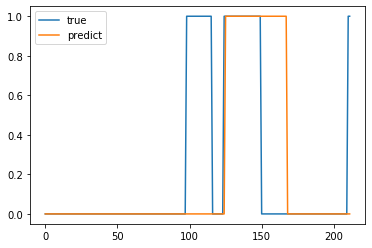

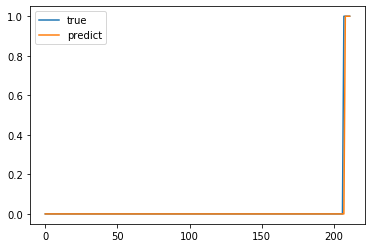

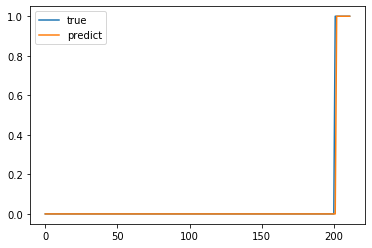

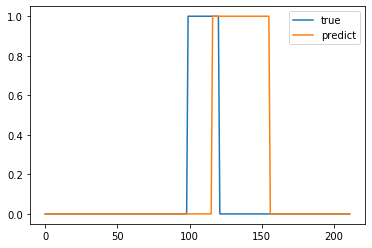

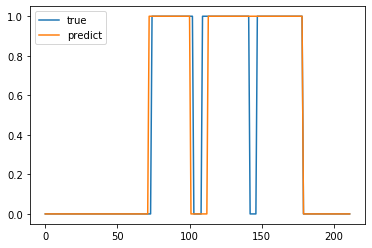

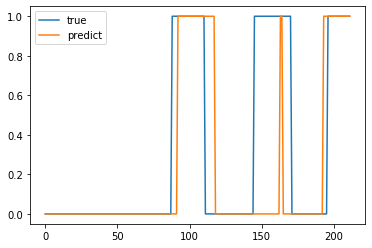

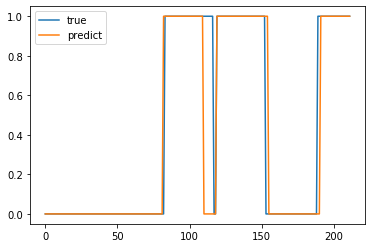

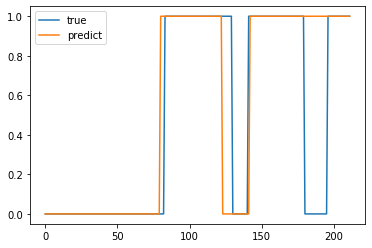

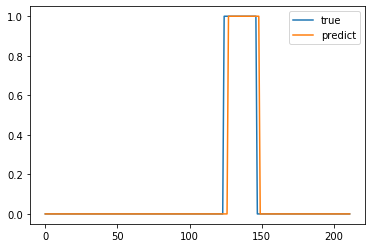

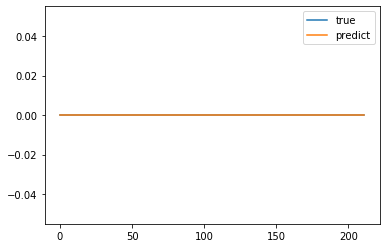

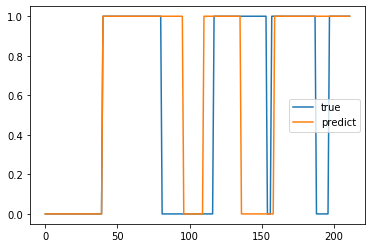

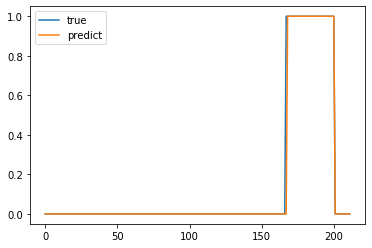

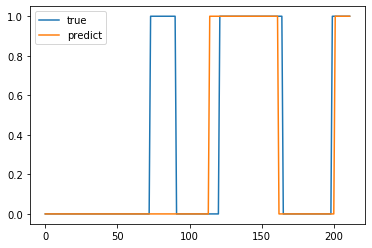

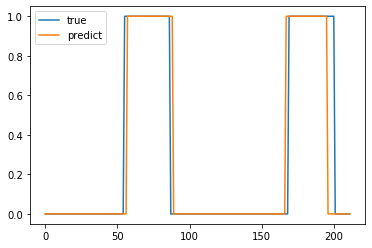

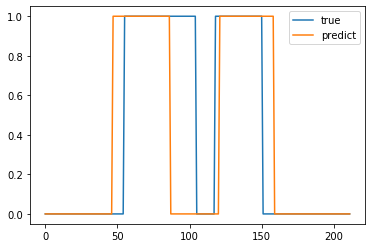

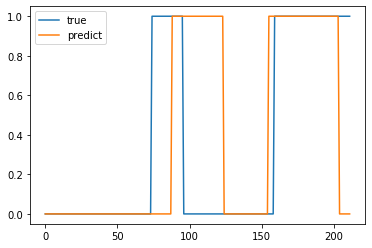

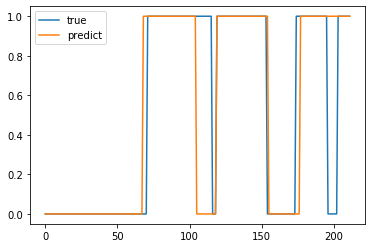

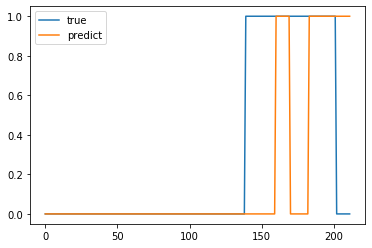

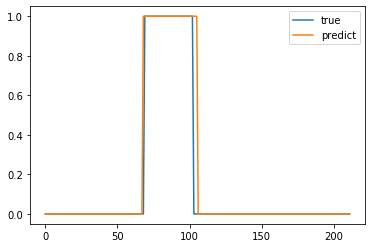

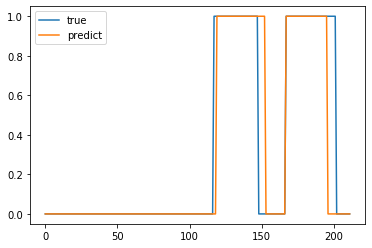

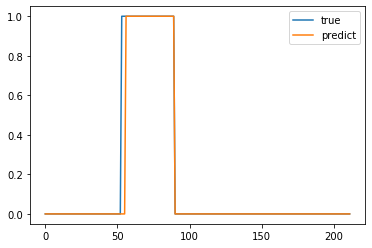

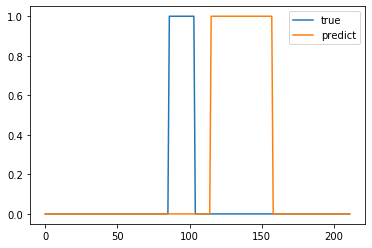

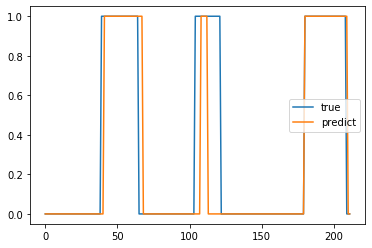

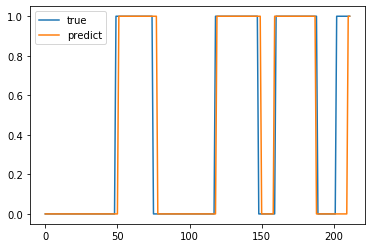

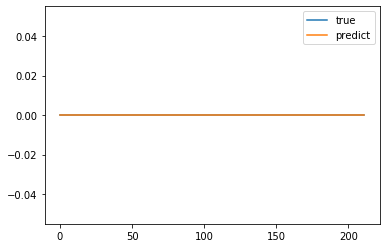

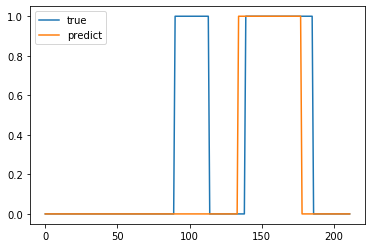

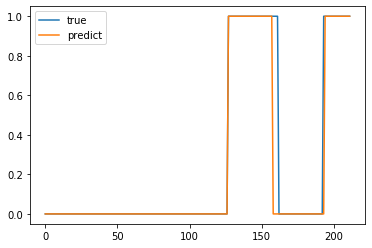

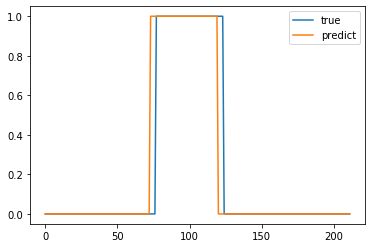

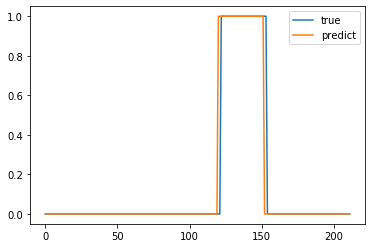

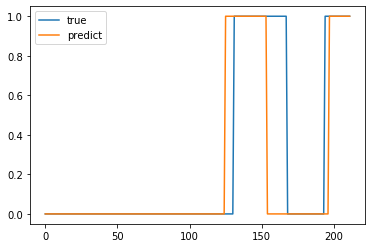

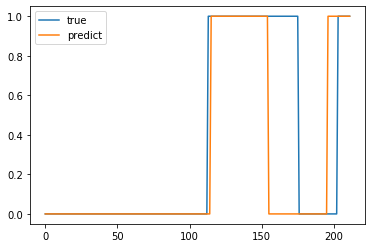

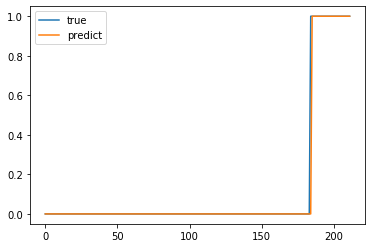

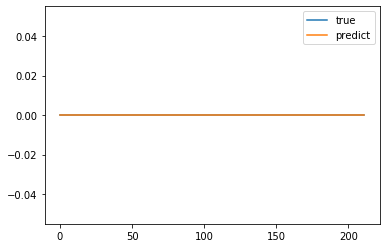

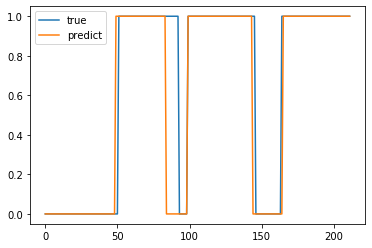

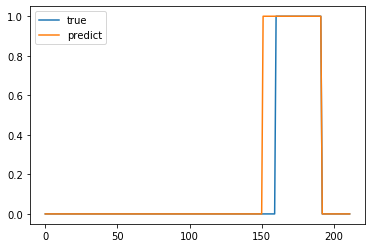

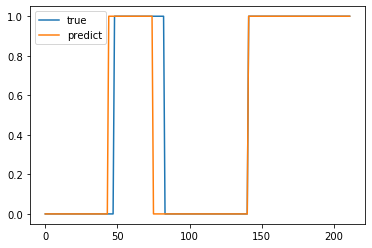

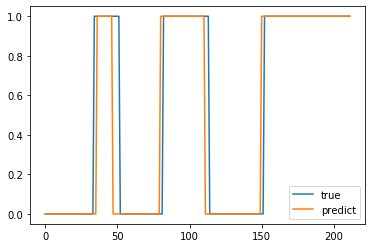

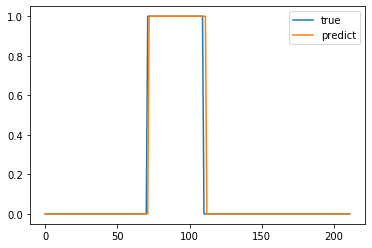

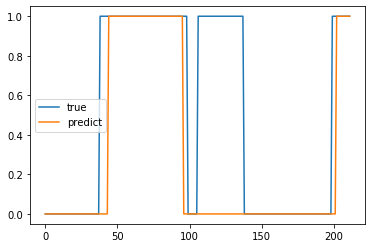

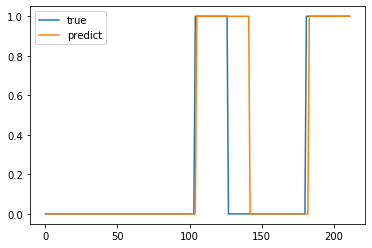

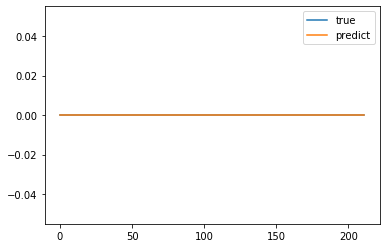

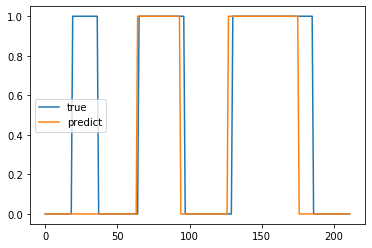

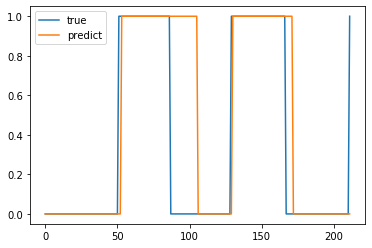

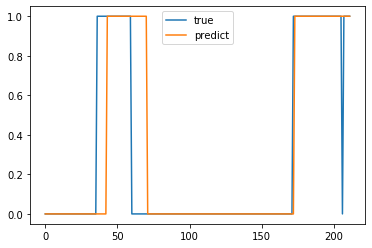

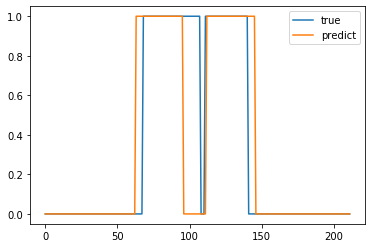

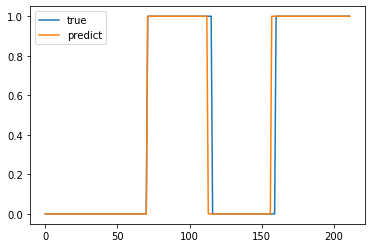

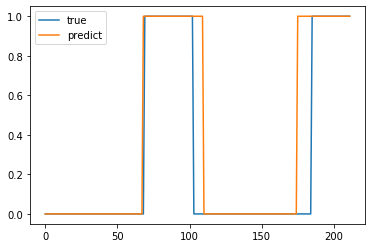

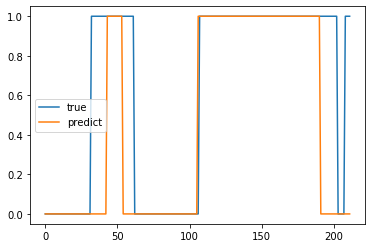

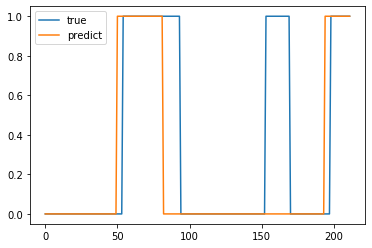

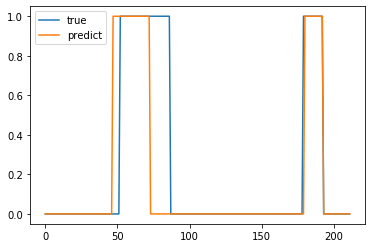

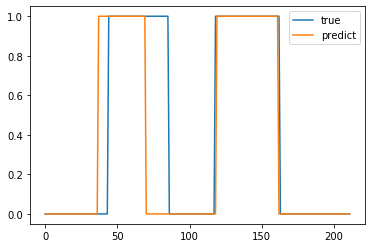

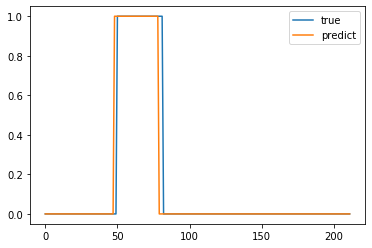

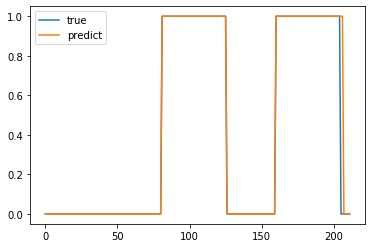

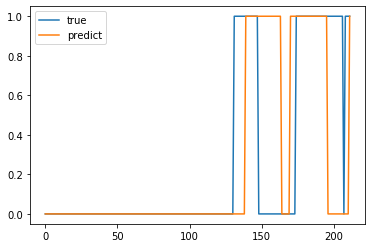

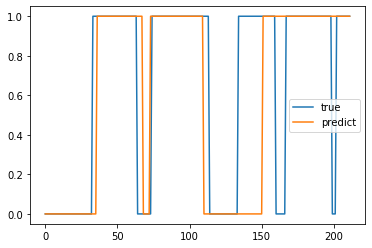

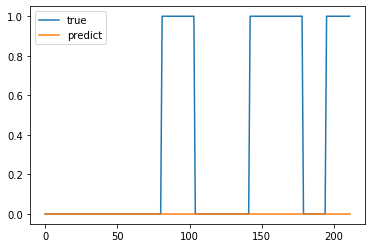

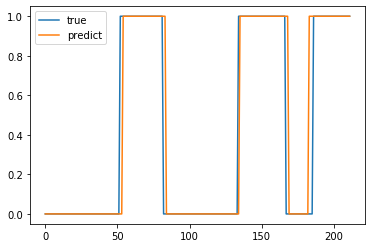

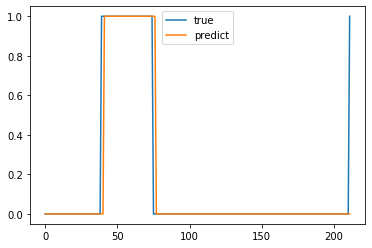

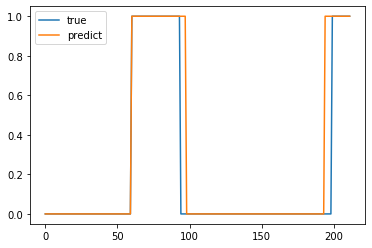

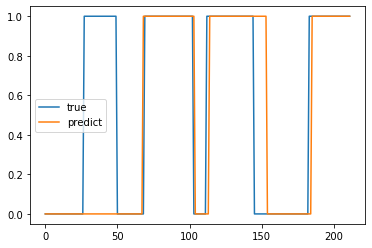

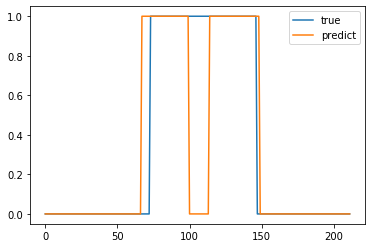

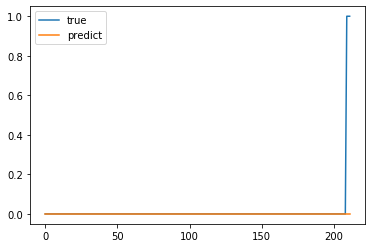

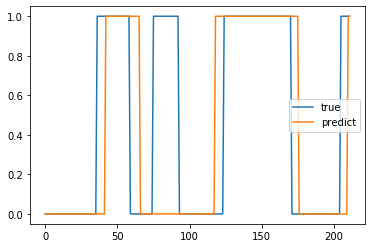

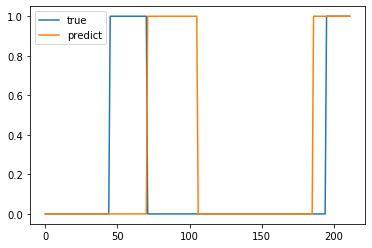

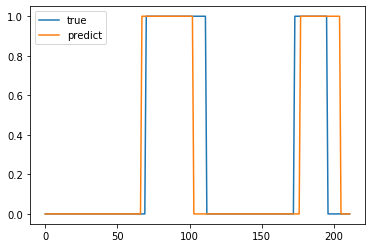

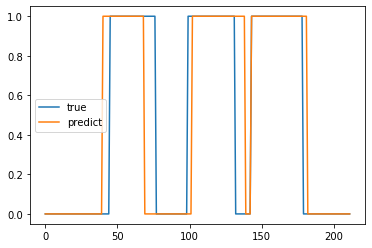

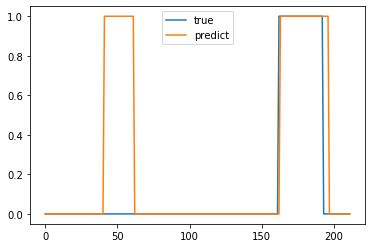

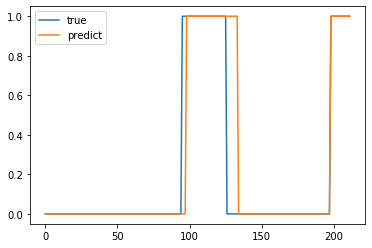

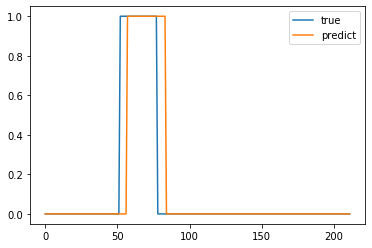

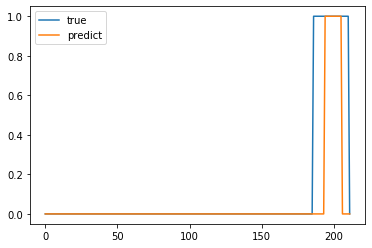

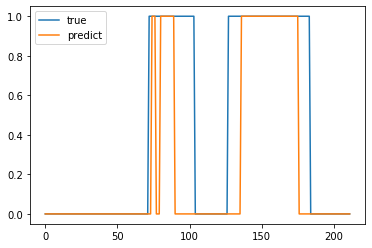

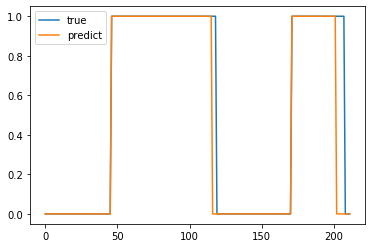

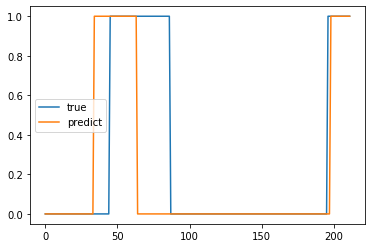

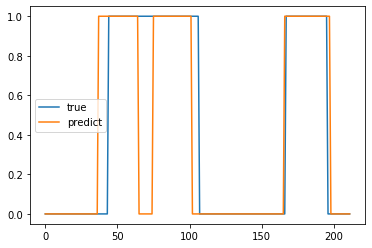

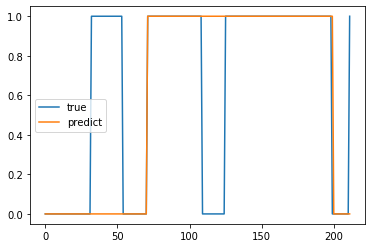

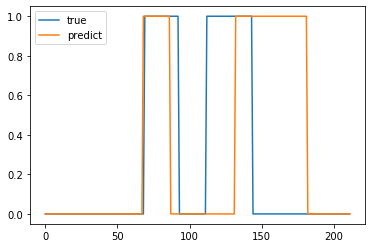

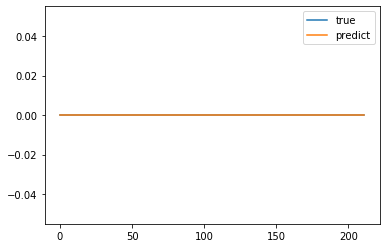

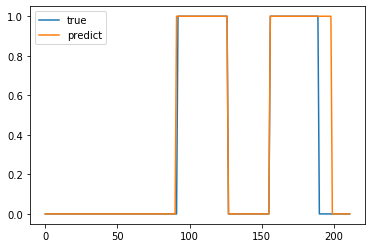

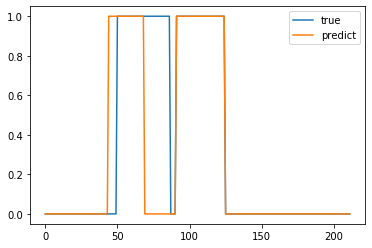

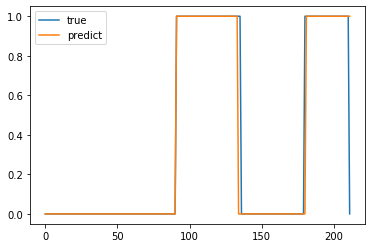

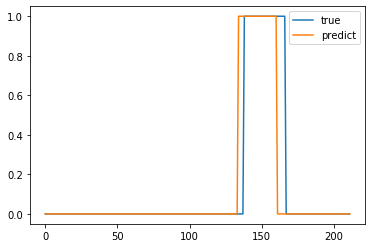

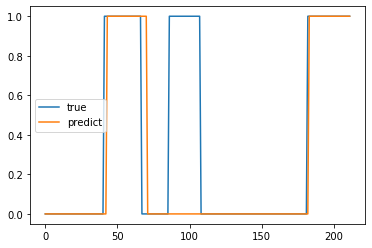

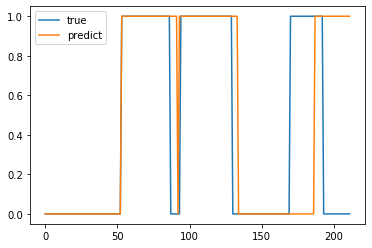

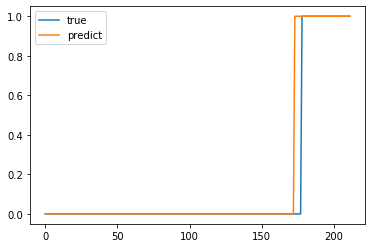

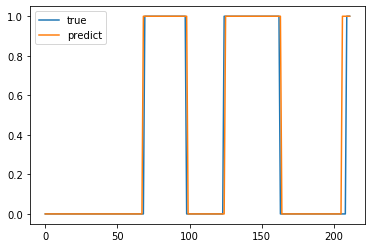

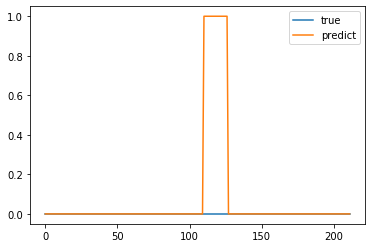

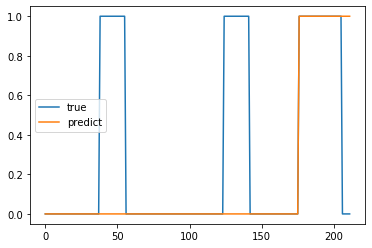

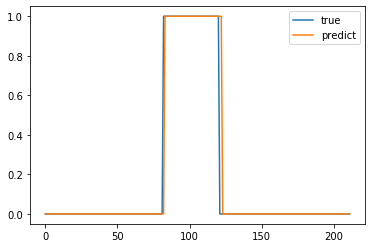

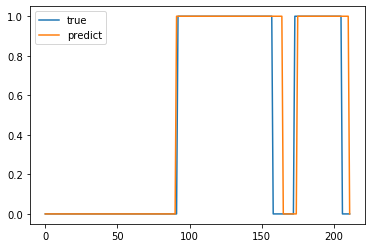

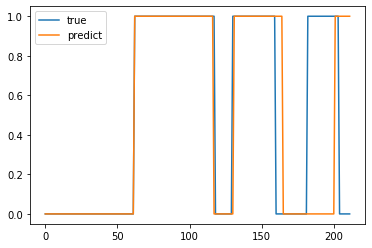

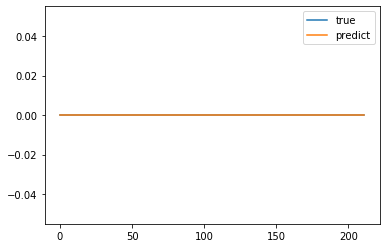

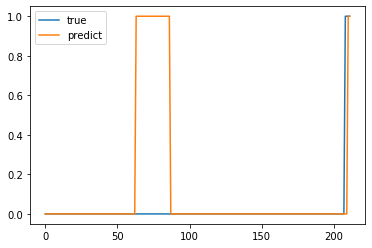

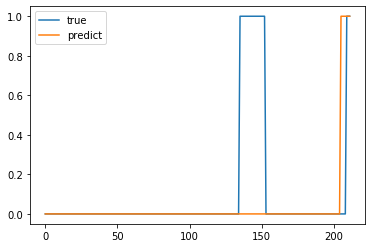

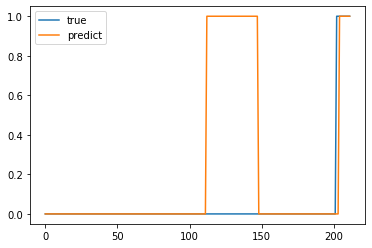

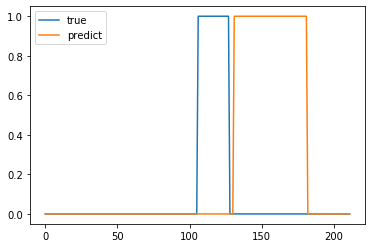

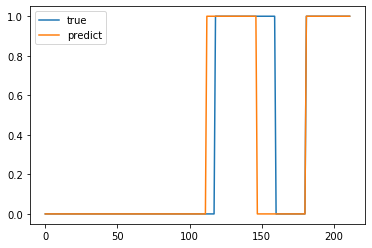

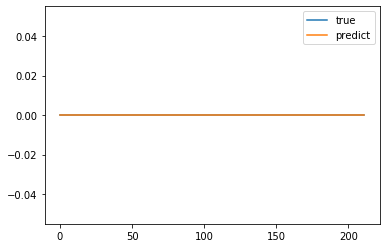

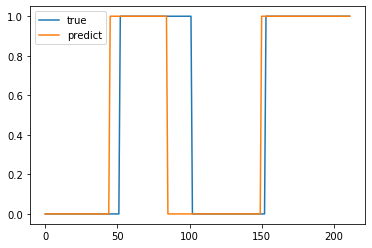

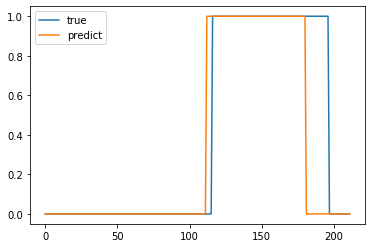

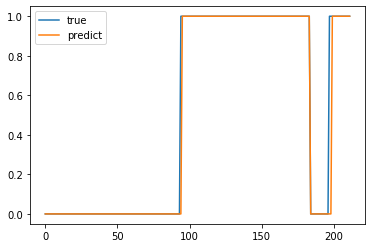

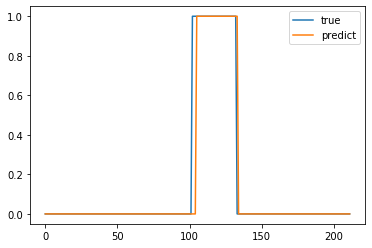

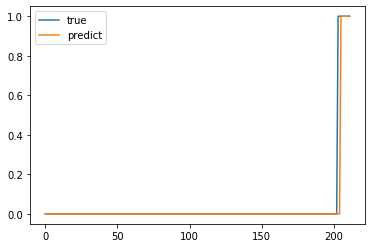

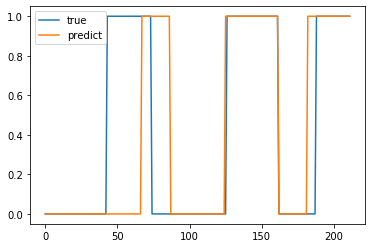

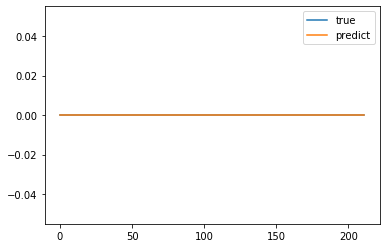

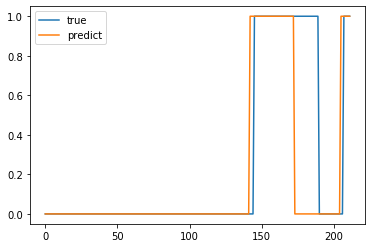

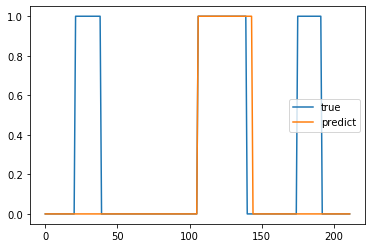

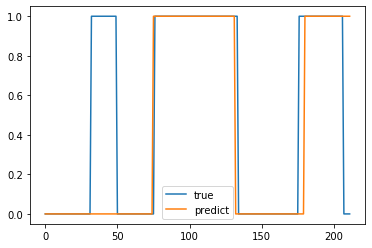

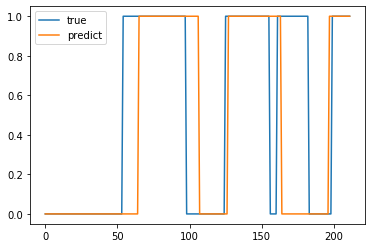

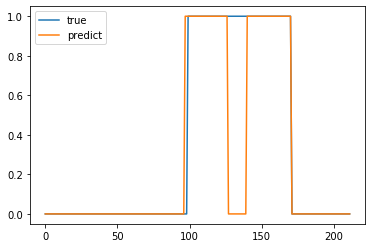

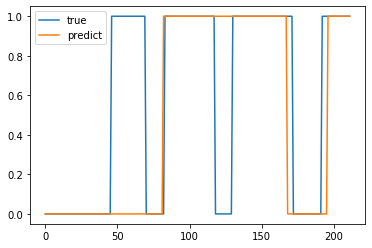

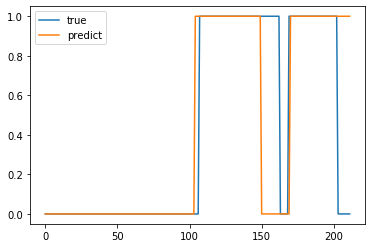

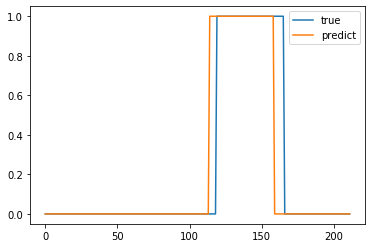

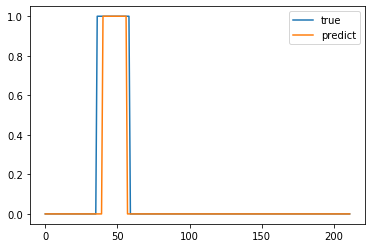

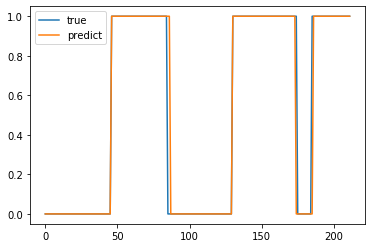

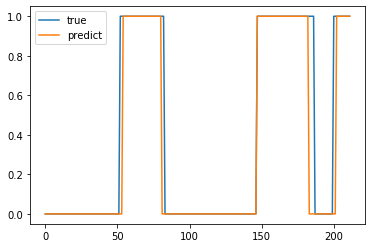

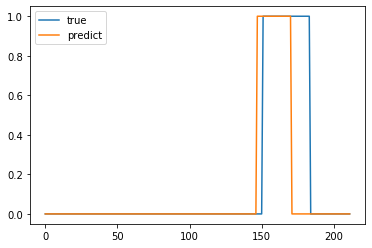

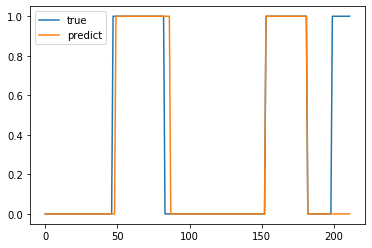

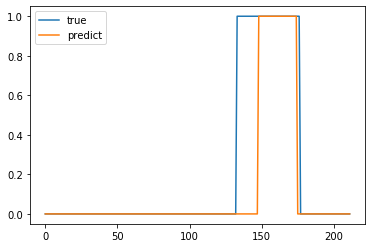

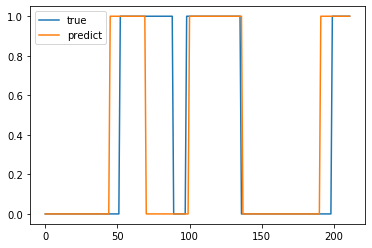

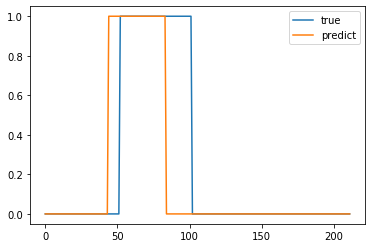

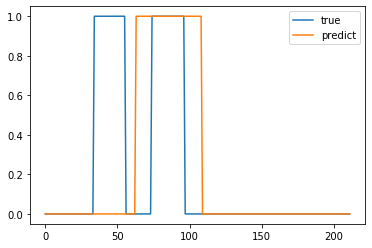

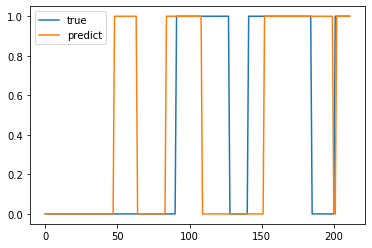

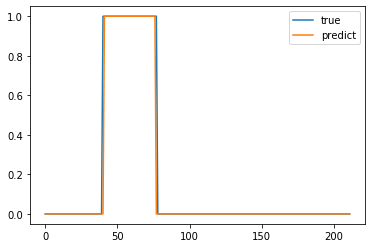

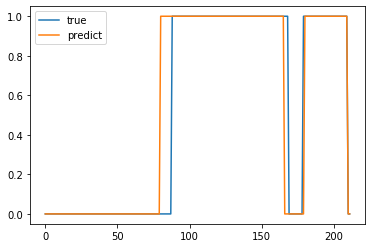

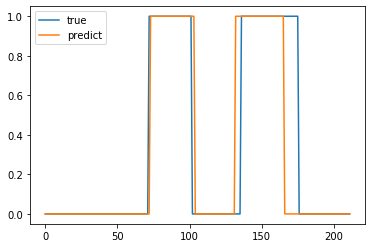

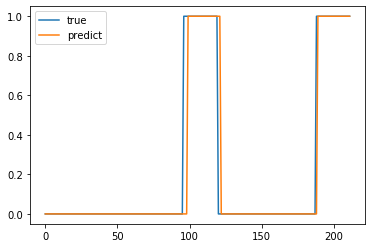

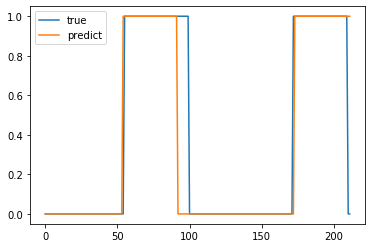

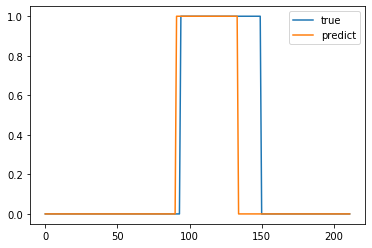

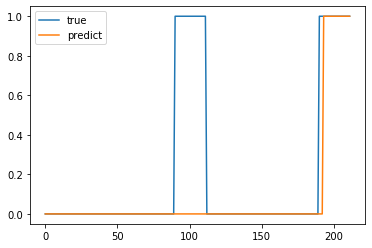

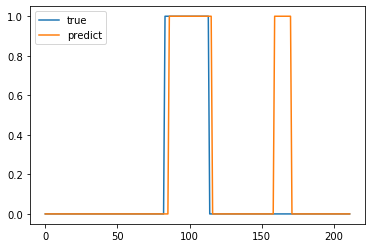

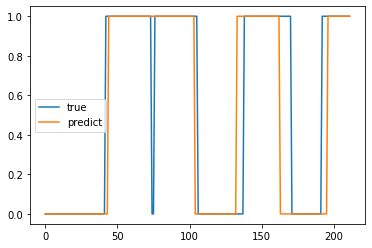

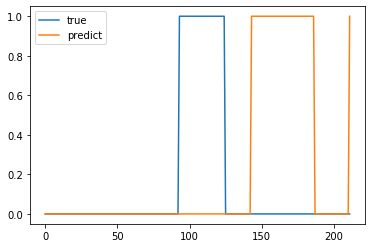

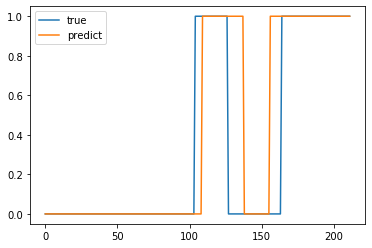

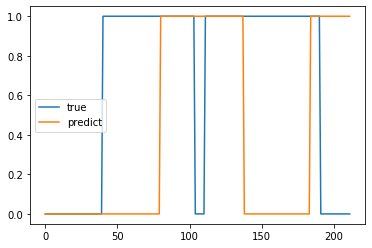

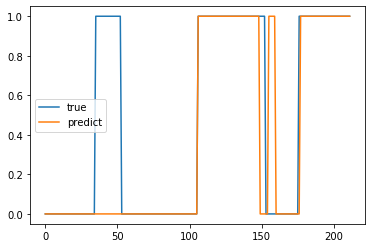

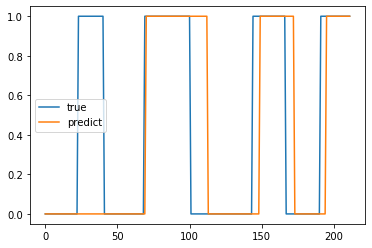

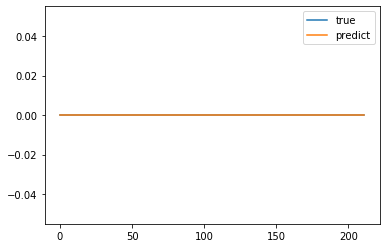

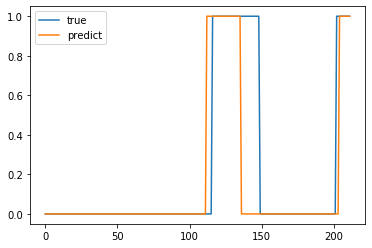

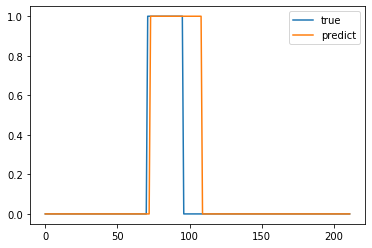

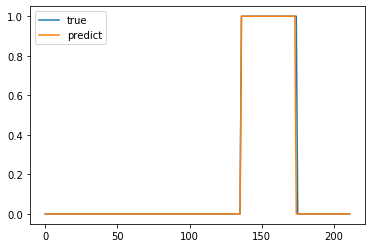

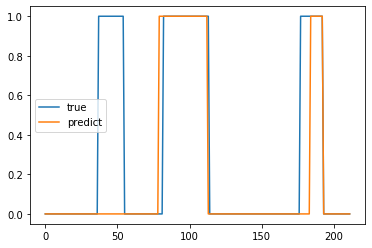

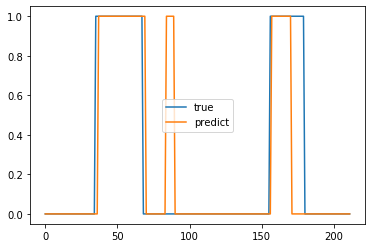

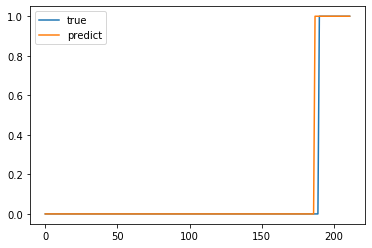

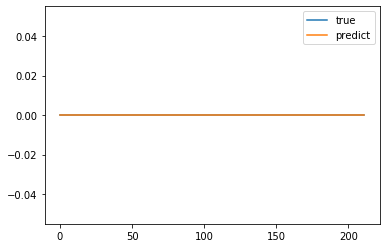

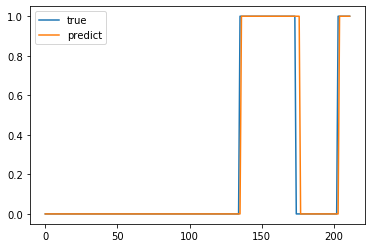

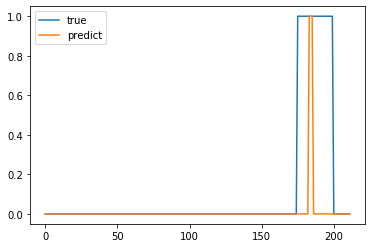

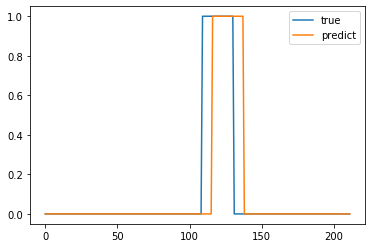

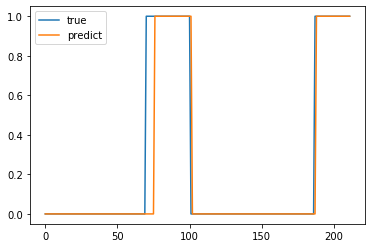

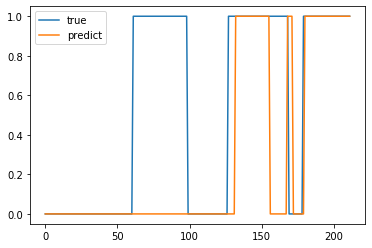

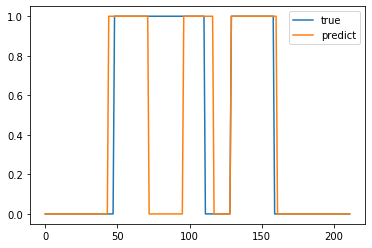

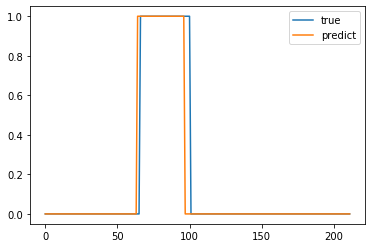

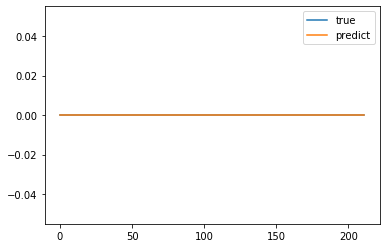

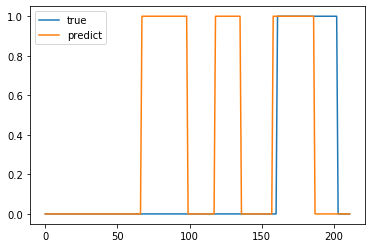

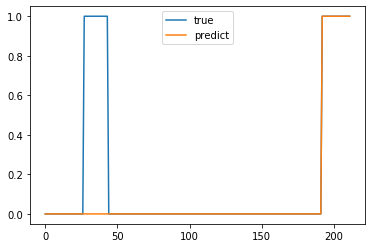

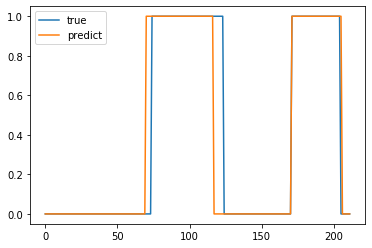

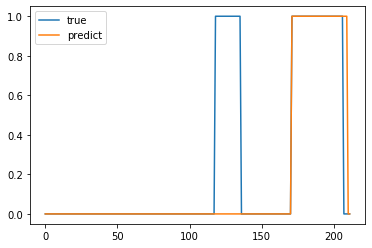

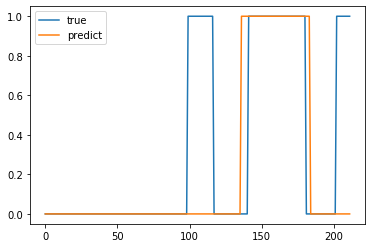

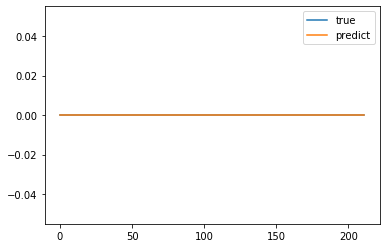

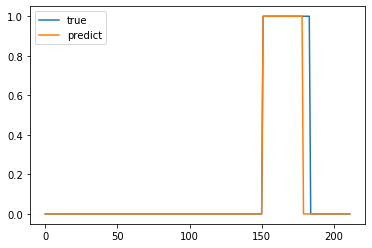

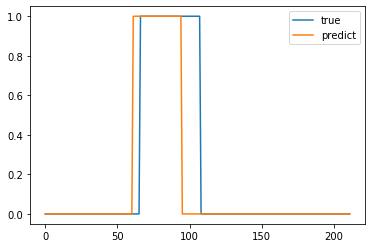

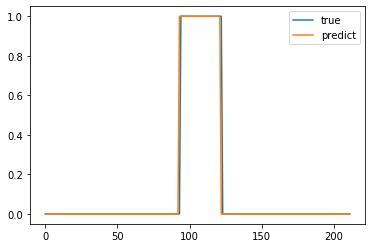

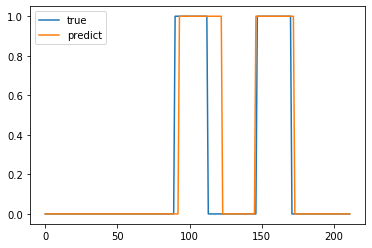

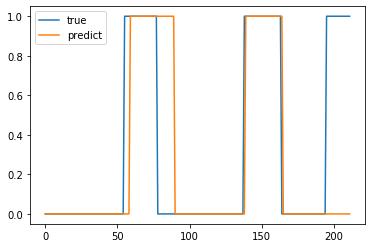

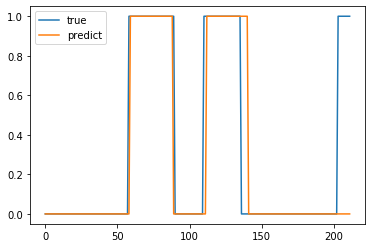

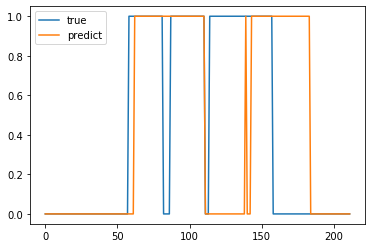

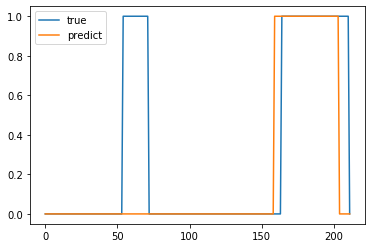

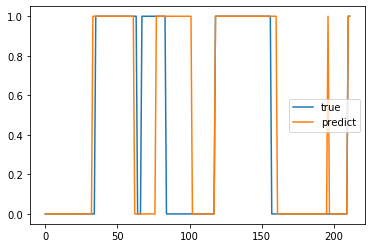

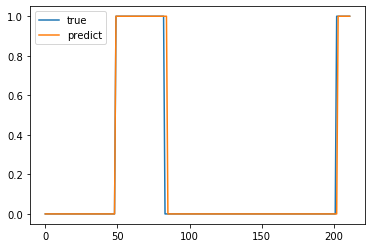

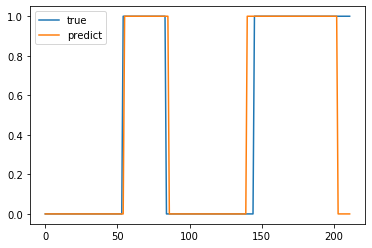

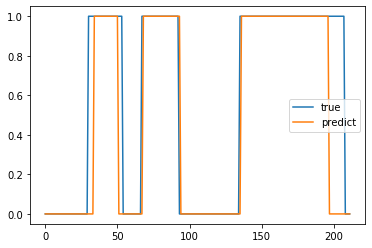

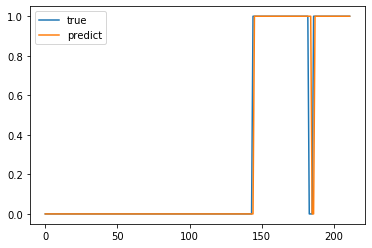

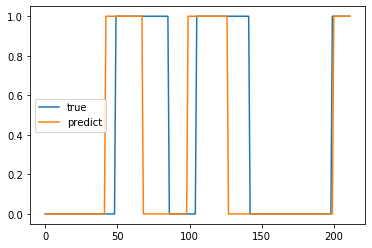

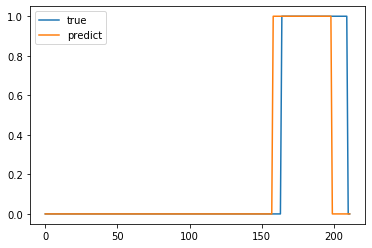

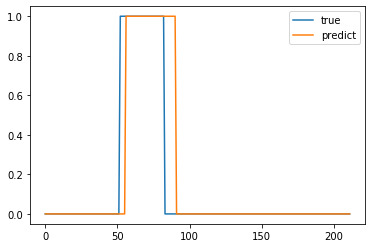

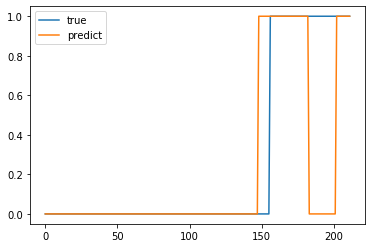

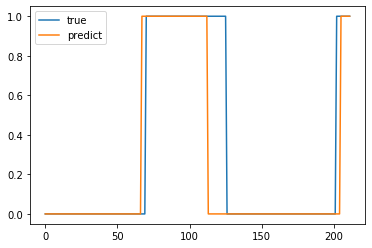

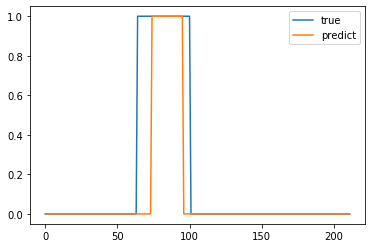

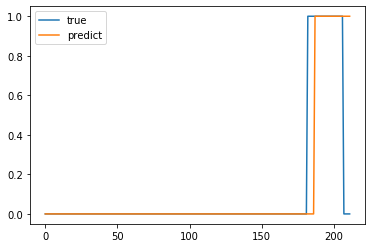

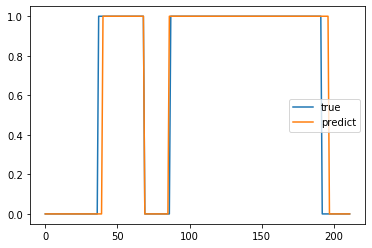

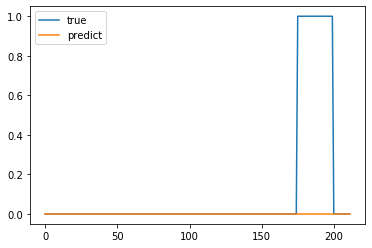

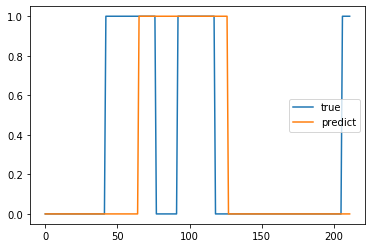

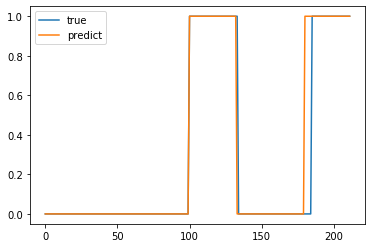

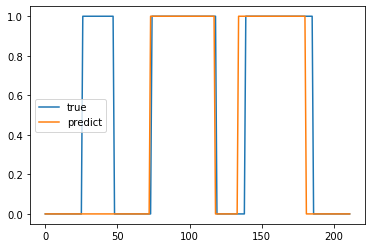

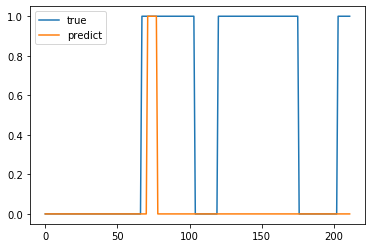

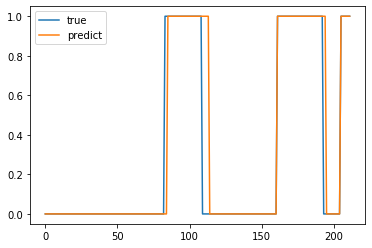

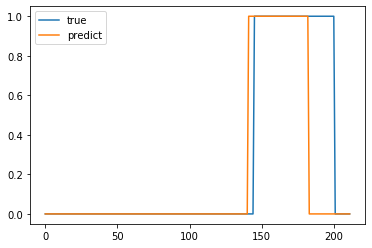

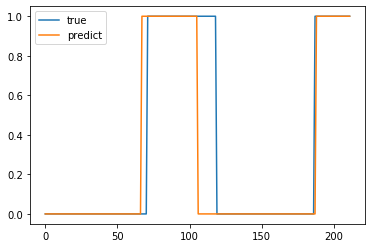

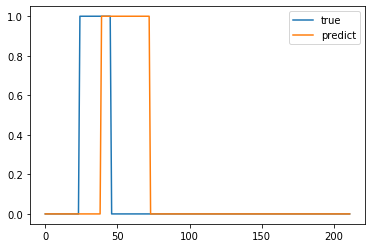

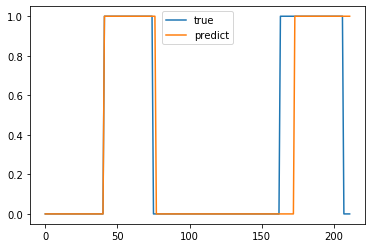

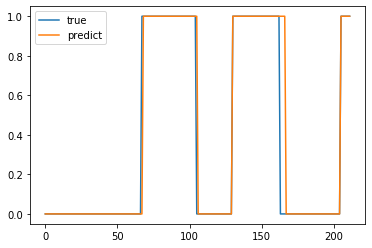

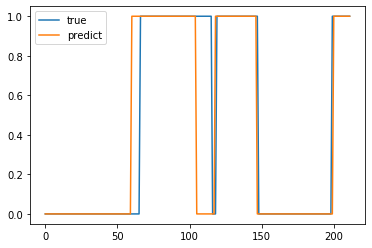

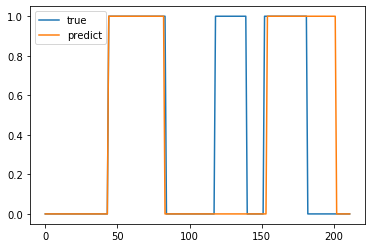

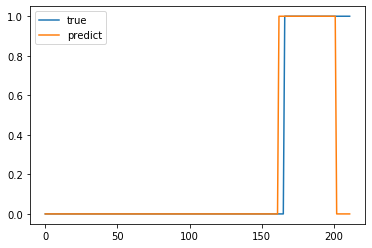

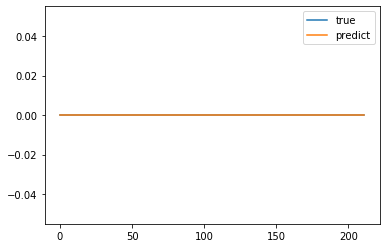

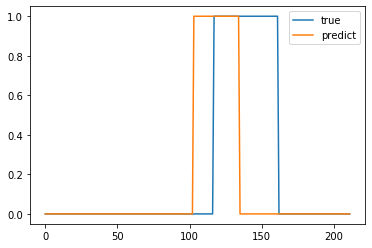

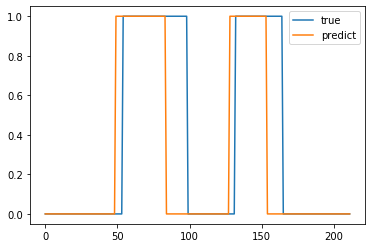

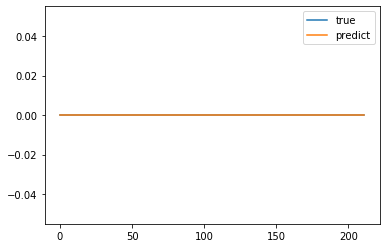

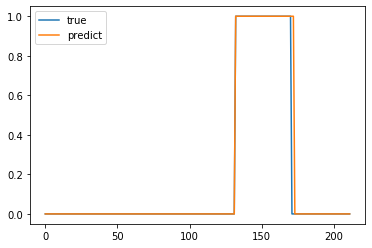

In [ ]:
import matplotlib.pyplot as plt
for batch in test_generator:
    x, y = batch
    output = loaded_model.predict(x)
    output = postprocessing(output,0.6)
    for i in range(len(y)):
        plt.plot(y[i], label='true')
        plt.plot(output[i], label='predict')
        plt.legend()
        plt.show()